# Import libraries

In [1]:
from utils.coords.transforms import *
from utils.coords.metrics import *
from utils.load_config import load_config

In [52]:
from utils.telescope.bandpass.bandpass_gains import *

In [2]:
from utils.rime.rime_comps import *

In [3]:
from utils.rfi.rfi_spectra.sim_rfi_spectra import get_rfi_spectra

In [4]:
from utils.rfi.sat_sim.satellite_simulations import get_dist_and_seps, get_archival_tles

In [5]:
from utils.telescope.beams import auto_beam, cross_beam

In [6]:
from skyfield.api import load as sf_load

In [7]:
import matplotlib.pyplot as plt

In [8]:
import datetime

In [9]:
%matplotlib inline

# Load Config

In [10]:
config = load_config('config.yml')


No frequency ranges set for satellites.

No frequency ranges set for cell_towers.

No frequency ranges set for planes.

No GPS coordinates set for cell towers.

No flight paths set for planes.


# Calculate obs times

In [11]:
all_times = [config['observation']['start_datetime'] + i*config['observation']['int_time'] 
             for i in range(config['observation']['time_steps'])]

# Choose target and astro sources

In [12]:
astro = config['astronomical']['sky_model']

In [13]:
sep = angular_separation(astro[:,0], astro[:,1], config['observation']['target'])

In [14]:
np.argmin(sep), np.min(sep)

(272634, 0.15009923799627237)

In [15]:
astro[np.argmin(sep), :2], config['observation']['target']

(array([ 20.827, -29.991]), array([ 21., -30.]))

In [16]:
config['observation']['target'] = astro[np.argmin(sep), :2]

In [17]:
sep = angular_separation(astro[:,0], astro[:,1], config['observation']['target'])

In [18]:
chosen = np.where(sep<config['astronomical']['radius'])[0]

In [19]:
chosen.shape

(1,)

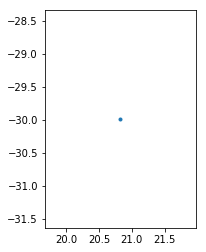

In [20]:
plt.plot(astro[chosen,0], astro[chosen,1], '.')
plt.gca().set_aspect('equal', adjustable='box')

In [21]:
config['astronomical']['inview'] = astro[chosen]

# Calculate UVW coords

In [22]:
ra, dec = config['observation']['target']

In [23]:
enu = config['telescope']['ENU_coords']

In [24]:
lat, lon, el = config['telescope']['GPS_coords']

In [25]:
uvw = ENU_to_UVW(enu, lat, lon, ra, dec, all_times)

# Get frequencies

In [26]:
freqs = config['telescope']['frequencies']

# Calculate brightness matrices - astro

In [27]:
freq0 = 863e6
I, SI = config['astronomical']['inview'][:,2:].T
I_astro = I[None,None,:]*(freqs[None,:,None]/freq0)**SI[None,None,:]
Q = np.zeros_like(I_astro)
U = np.zeros_like(I_astro)
V = np.zeros_like(I_astro)
B_astro = brightness_matrix(I_astro, Q, U, V)

In [28]:
B_astro.shape

(2, 2, 1, 4096, 1)

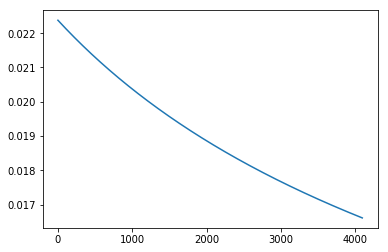

In [29]:
plt.plot(B_astro[1,1,0,:,:3].real)

# Calculate phase delays - astro

In [30]:
lmn = np.array(radec_to_lmn(config['astronomical']['inview'][:,0], 
                   config['astronomical']['inview'][:,1],
                   config['observation']['target'])).T

In [31]:
distances = np.dot(uvw, lmn.T)

In [32]:
distances.shape

(10, 64, 1)

In [33]:
K_astro = phase_delays(distances, freqs)

# Calculate DDE - astro

In [34]:
# E_astro = pol_beam_astro(lmn)

# Choose satellites

In [35]:
config['observation']['duration']

datetime.timedelta(0, 10)

In [36]:
start_obs = config['observation']['start_datetime']
obs_time = config['observation']['duration']
gps_ants = ENU_to_GPS_el(config['telescope']['GPS_coords'], config['telescope']['ENU_coords'])
one_day = datetime.timedelta(days=1)
start_obs_ntz = start_obs.replace(tzinfo=None)
tles = sf_load.tle(get_archival_tles(start_obs_ntz-one_day, start_obs_ntz+one_day))

File 2019-02-20.tle exists and is readable.


In [37]:
obs_times = [start_obs+i*0.5*obs_time for i in range(3)]
el_dist_ra_dec_sep = get_dist_and_seps(list(tles.values()), gps_ants, obs_times, [ra, dec])
means = np.mean(el_dist_ra_dec_sep, axis=(0,1), keepdims=True)
selected_sats = np.where((means[:,:,:,0]>0) & (means[:,:,:,-1]<30))[2]
selected_sat_ids = np.array(list(tles.keys()))[selected_sats].astype(int)
selected_tles = [tles[i] for i in selected_sat_ids]

In [38]:
int_time = config['observation']['int_time']

In [39]:
obs_times = [start_obs+i*int_time for i in range(int(obs_time/int_time))]
el_dist_ra_dec_sep = get_dist_and_seps(selected_tles, gps_ants, obs_times, [ra,dec])

In [40]:
n_time = config['observation']['time_steps']
n_freq = len(freqs)
n_rfi = el_dist_ra_dec_sep.shape[-2]

# Calculate brightness matrices - rfi

In [41]:
rfi_spectra = np.transpose(get_rfi_spectra(n_freq, n_rfi, n_time), (3,1,2,0))

In [42]:
n_rfi

10

In [43]:
rfi_spectra.shape

(4, 10, 4096, 10)

In [44]:
B_rfi = brightness_matrix(rfi_spectra[0], rfi_spectra[1], rfi_spectra[2], rfi_spectra[3])

In [45]:
B_rfi.shape

(2, 2, 10, 4096, 10)

# Calculate phase delays - rfi

In [46]:
K_rfi = phase_delays(el_dist_ra_dec_sep[:,:,:,1], freqs)

In [47]:
K_rfi.shape

(10, 4096, 64, 10)

# Calculate DDE - rfi

In [48]:
el_dist_ra_dec_sep.shape

(10, 64, 10, 5)

In [49]:
# E_rfi = pol_beam(sinc_beam, None, [0.0, freqs], el_dist_ra_dec_sep[:,:,:,-1])

In [50]:
E_rfi = pol_beam(el_dist_ra_dec_sep[:,:,:,2], 
                 el_dist_ra_dec_sep[:,:,:,3], 
                 freqs, config['observation']['target'],
                 auto_beam, cross_beam)

In [51]:
E_rfi.shape

(2, 2, 10, 4096, 64, 10)

# Calculate gains

In [53]:
G = get_bandpass_and_gains(config['astronomical']['inview'][0,2], 
                           np.array([time.timestamp() for time in obs_times]))

In [54]:
G = np.transpose(gains(G[0]), (0,1,2,4,3))

In [55]:
G.shape

(2, 2, 10, 4096, 64)

# Compute RIME - astro

# Compute RIME - rfi

In [56]:
B_rfi.shape, K_rfi.shape, E_rfi.shape, G.shape

((2, 2, 10, 4096, 10),
 (10, 4096, 64, 10),
 (2, 2, 10, 4096, 64, 10),
 (2, 2, 10, 4096, 64))

In [ ]:
V_rfi = RIME(B_rfi, K_rfi, E_rfi, G)

In [ ]:
whos